In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from my_main2 import Net,test
from torchvision import datasets, transforms

In [4]:
model_file = 'mnist2_98.4_0.0100_SGD_gfusedmax_1_1.00_10.00.pt'
params = model_file.strip('.pt').split('_')
_,acc,lr,optim_type,max_type,norm_flag,lam,gamma = \
    params[0],float(params[1]),float(params[2]),params[3],params[4],bool(int(params[5])),float(params[6]),float(params[7])
model = Net(max_type,norm_flag,lam,gamma)
model.load_state_dict(torch.load(model_file,map_location='cpu'))

In [6]:
model.eval()
use_cuda = torch.cuda.is_available()
use_cuda = False
device = torch.device("cuda" if use_cuda else "cpu")
model = model.to(device)
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', download=True, train=False, transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=1000, shuffle=True, **kwargs)
test_acc = test(None, model, device, test_loader)
print(test_acc)

Processing...
Done!

Test set: Average loss: 0.0475, Accuracy: 9843/10000 (98%)

0.9843


In [7]:
print(type(test_loader.dataset.test_data),test_loader.dataset.test_data.size())
test_data = test_loader.dataset.test_data

<class 'torch.Tensor'> torch.Size([10000, 28, 28])


In [8]:
import torch.nn as nn
import torch.nn.functional as F
def forward_att(att,x):
    N,C,H,W = x.size()
    x = x.reshape([N,H,W,C])
    proj_x = att.proj_func(x)
    score_x = att.score_func(x)
    scores = torch.reshape(score_x,[N,-1,1])
    projs = torch.reshape(proj_x,[N,-1,att.output_size])
    weights = att.mapping_func(att.score_norm(scores),dim=-2)
    output = torch.sum(projs * weights,dim=-2)
    return proj_x,score_x,weights.reshape(score_x.size()),output
def forward(model,x):
    h1 = F.relu(model.conv1(x))
    h1_pooled = F.max_pool2d(h1, 2, 2)
    h2 = F.relu(model.conv2(h1_pooled))
    h2_pooled = F.max_pool2d(h2, 2, 2)
    h3 = F.relu(model.attention_pool(h2_pooled).view(-1,500))
    h4 = model.fc2(h3)
    return h1,h1_pooled,h2,h2_pooled,h3,h4
norm_image = lambda x: (x.type(torch.float)/255.-0.1307)/0.3081

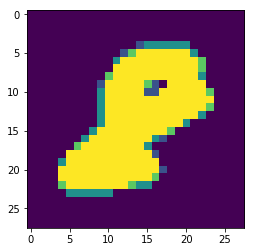

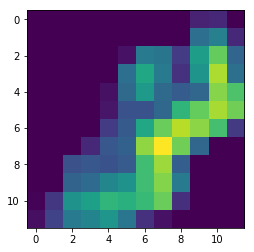

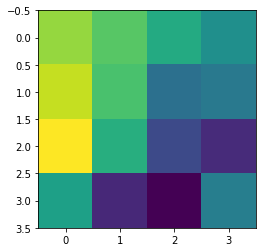

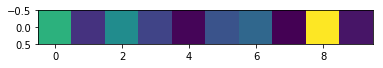

torch.Size([1, 4, 4, 500]) torch.Size([1, 4, 4, 1]) torch.Size([1, 4, 4, 1]) torch.Size([1, 500])


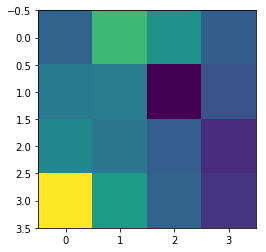

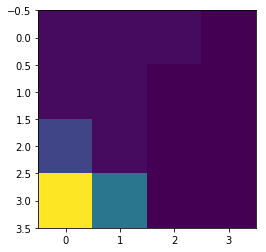

In [9]:
with torch.no_grad():
    index = np.random.choice(test_data.size()[0])
    plt.imshow(test_data[index])
    plt.show()
    h1,h1_pooled,h2,h2_pooled,h3,h4 = forward(model,norm_image(test_data[index]).unsqueeze_(0).unsqueeze(0))
    plt.imshow(h1_pooled[0,10])
    plt.show()
    plt.imshow(h2_pooled[0,10])
    plt.show()
    plt.imshow(h4)
    plt.show()
    proj,score,weights,att_out = forward_att(model.attention_pool,h2_pooled)
    print(proj.shape,score.shape,weights.shape,att_out.shape)
    plt.imshow(score[0,:,:,0])
    plt.show()
    plt.imshow(weights[0,:,:,0])
    plt.show()

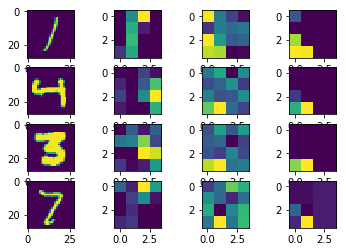

In [13]:
samples = 4
sample_per_row = 4
plt.axis('off')
with torch.no_grad():
    for s in range(samples):
        index = np.random.choice(test_data.size()[0])
        plt.subplot(np.ceil(samples*4/sample_per_row),sample_per_row,4*s+1)
        plt.imshow(test_data[index])
        h1,h1_pooled,h2,h2_pooled,h3,h4 = forward(model,norm_image(test_data[index]).unsqueeze_(0).unsqueeze(0))
        plt.subplot(np.ceil(samples*4/sample_per_row),sample_per_row,4*s+2)
        plt.imshow(h2_pooled[0,20,:,:])
        proj,score,weights,att_out = forward_att(model.attention_pool,h2_pooled)
        plt.subplot(np.ceil(samples*4/sample_per_row),sample_per_row,4*s+3)
        plt.imshow(score[0,:,:,0])
        plt.subplot(np.ceil(samples*4/sample_per_row),sample_per_row,4*s+4)
        plt.imshow(weights[0,:,:,0])
plt.show()

In [16]:
with torch.no_grad():
    h1,h1_pooled,h2,h2_pooled,h3,h4 = forward(model,norm_image(test_data).unsqueeze_(1))
    proj,score,weights,att_out = forward_att(model.attention_pool,h2_pooled)
    all_weights = np.sum(np.abs(weights[:,:,:,0].numpy()),axis=0)
print(all_weights)

[[ 238.83179   162.43933   118.91108   118.7856  ]
 [ 184.40924   152.71709    90.28653    93.73606 ]
 [1108.428     137.04001    91.04849    93.82153 ]
 [4051.8384   3167.1382     94.686066   95.89013 ]]


In [17]:
np.sum(all_weights)

10000.007

In [23]:
len(test_data)

10000

In [24]:
weights = weights.squeeze().numpy()
print(weights.shape)
print(np.sum(weights,axis=(1,2)))

(10000, 4, 4)
[3.8399372 4.526389  4.582712  ... 4.021746  4.1189194 4.401153 ]


In [37]:
print(model.attention_pool)
print(model.attention_pool.mapping_func(score[5:6].reshape(1,16,1),-2))

ConvAddAttention(
  (gfusedmax_module): Gfusedmax()
  (proj_func): Linear(in_features=50, out_features=500, bias=True)
  (score_func): Linear(in_features=50, out_features=1, bias=True)
  (score_norm): LayerNorm(torch.Size([16, 1]), eps=1e-05, elementwise_affine=True)
)
tensor([[[0.2087],
         [0.2087],
         [0.2087],
         [0.2087],
         [0.2087],
         [0.2087],
         [0.2087],
         [0.2087],
         [0.9464],
         [0.2087],
         [0.2087],
         [0.2087],
         [1.9366],
         [0.0000],
         [0.2087],
         [0.2087]]])


In [40]:
print(model.attention_pool.input_A[0,:,:,0])

tensor([[0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0

In [42]:
print(model.attention_pool.gfusedmax_module(score[5:6].reshape(1,16,1),model.attention_pool.input_A,dim=-2))

tensor([[[0.2087],
         [0.2087],
         [0.2087],
         [0.2087],
         [0.2087],
         [0.2087],
         [0.2087],
         [0.2087],
         [0.9464],
         [0.2087],
         [0.2087],
         [0.2087],
         [1.9366],
         [0.0000],
         [0.2087],
         [0.2087]]])


In [45]:
tmp_score = score[5:6].reshape(1,16,1)
fused = model.attention_pool.gfusedmax_module.gfusedlasso_func(tmp_score,model.attention_pool.input_A,dim=-2)
sparse = model.attention_pool.gfusedmax_module.sparsemax_func(fused,dim=-2)
print(tmp_score.size(),fused.size(),sparse.size())

torch.Size([1, 16, 1]) torch.Size([1, 16, 1]) torch.Size([1, 16, 1])


In [55]:
from torch_mapping import torch_sparsemax, sparsemax
print(torch_sparsemax().apply(fused,-2,10.0))
print(fused[0,:,0])
print(torch_sparsemax().apply(fused[0,:,0],-1,10.0))
print(sparsemax(fused[0,:,0].numpy(),10.0))

tensor([[[0.2087],
         [0.2087],
         [0.2087],
         [0.2087],
         [0.2087],
         [0.2087],
         [0.2087],
         [0.2087],
         [0.9464],
         [0.2087],
         [0.2087],
         [0.2087],
         [1.9366],
         [0.0000],
         [0.2087],
         [0.2087]]])
tensor([ 0.1761,  0.1761,  0.1761,  0.1761,  0.1761,  0.1761,  0.1761,  0.1761,
         0.9138,  0.1761,  0.1761,  0.1761,  1.9040, -0.7119,  0.1761,  0.1761])
tensor([0.2087, 0.2087, 0.2087, 0.2087, 0.2087, 0.2087, 0.2087, 0.2087, 0.9464,
        0.2087, 0.2087, 0.2087, 1.9366, 0.0000, 0.2087, 0.2087])
[0.05022943 0.05022939 0.0502294  0.05022942 0.0502295  0.05022937
 0.05022936 0.05022926 0.12400005 0.0502293  0.05022912 0.05022902
 0.22301966 0.         0.05022887 0.05022887]
